# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import line_profiler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.special import gamma
import seaborn as sns
sns.set(color_codes=True)
import state_space as ss
import statsmodels.api as sm
import time
import typing as tp
import xarray as xr
# xr.set_options(display_style="html");

In [4]:
plt.rcParams["figure.figsize"] = (18,12)

In [5]:
pd.set_option('display.max_rows', 250)

# Read Data

## Returns

In [6]:
# spy_filename = os.path.join('data', 'GSPC.csv')
spy_filename = os.path.join('data', 'SPY.csv')

In [7]:
df = pd.read_csv(spy_filename)

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.sort_values('Date', inplace=True)

In [10]:
df = df.dropna()

In [11]:
df['Log_Return'] = np.log(df['Close']).diff()

In [12]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Return
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.583992,1003200,NaN
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.773048,480500,0.007087
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.829773,201300,0.002116
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,27.113388,529400,0.010515
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,27.226835,531500,0.004175


## Factor Data

In [13]:
factor_filename = os.path.join('data', 'F-F_Research_Data_Factors_daily.CSV')

In [14]:
factors \
    = pd.read_csv(factor_filename, 
                  engine='python', 
                  skiprows=5, 
                  names=['Date', 'Mkt-RF', 'SMB', 'HML', 'RF'], 
                  skipfooter=1)
factors['Date'] = pd.to_datetime(factors['Date'], format='%Y%m%d')
factors['RF'] *= 0.01
factors = factors.dropna()

In [15]:
factors.tail(100)

,Date,Mkt-RF,SMB,HML,RF
24502,2019-06-12,-0.20,0.36,-0.89,0.00009
24503,2019-06-13,0.52,0.66,-0.01,0.00009
24504,2019-06-14,-0.27,-0.75,0.30,0.00009
24505,2019-06-17,0.15,0.61,-1.08,0.00009
24506,2019-06-18,1.04,0.20,0.19,0.00009
24507,2019-06-19,0.32,0.11,-0.59,0.00009
24508,2019-06-20,0.89,-0.36,-0.23,0.00009
24509,2019-06-21,-0.21,-0.45,-0.07,0.00009
24510,2019-06-24,-0.34,-0.92,0.15,0.00009
24511,2019-06-25,-0.98,0.34,0.74,0.00009


## Merge Returns and Risk-Free Rate

In [16]:
df = df.merge(factors.loc[:, ['Date', 'RF']], on='Date')

In [17]:
df['Excess_Return'] = df['Log_Return'] - np.log(1.0 + df['RF'])

In [18]:
df = df.dropna()

## Extract Time-Series

In [19]:
# log_returns = np.log(df['Close']).diff().dropna().values
log_returns = np.log(df['Close']).diff().values

In [20]:
r = np.log(1.0 + (df['RF'].values))

In [21]:
excess_returns = df['Excess_Return'].values

In [22]:
excess_returns.shape

(6738,)

In [23]:
r.shape

(6738,)

# Continuous-Time Model

Consider the unit of time to be one trading day (no time passes on weekends and holidays).

## Geometric Brownian Motion with Time-Varying Equity Premium

Dynamics of the equity premium:  
$d \mu_t = \kappa_{\mu} \left( \theta_{\mu} - \mu_t \right) dt + \sigma_{\mu} dB^{\mu}_t$

Log price dynamics:  
$dx_t = \left( r_t + \mu_t \right) dt + \sigma dB^x_t$

The Brownian motions $B^x$ and $B^{\mu}$ are uncorrelated.

SDE solution:  
$x_s - x_t = \mu (s - t) + \sigma \left( B_s - B_t \right)$

Euler Approximation of log-return and equity premium:  
$\left. x_s - x_t \right| x_t, \mu_t \sim N \left( (r_t + \mu_t) (s - t), \sigma^2 (s - t) \right)$  
$\left. {\mu}_s - {\mu}_t \right| x_t, \mu_t \sim N \left( \kappa_{\mu} \left( \theta_{\mu} - \mu_t \right) (s - t), \sigma_{\mu}^2 (s - t) \right)$  

One can rewrite the discretization of the equity premium as  
$\mu_{t+1} = \alpha + \beta \mu_t + \eta_t$,  
where $\alpha = \kappa_{\mu} \theta_{\mu}$ and $\beta = \kappa_{\mu} + 1$.

In [24]:
def transform_parameters(alpha_mu, beta_mu) -> tp.Tuple:
    kappa_mu = - np.log(beta_mu)
    theta_mu = alpha_mu / (1 - beta_mu)
    
    return kappa_mu, theta_mu

### Direct Estimation

In [25]:
sigma_hat_direct = np.std(excess_returns)
sigma_hat_direct

0.011470114292839896

In [26]:
mu_hat_direct = np.mean(excess_returns)
mu_hat_direct

0.00019258471875045288

### Linear State Space Representation and Kalman Filter

#### Statsmodels State-Space Model Estimation using Kalman Filtering

See https://www.statsmodels.org/stable/statespace.html

The time-varying equity premium model is a linear state space model of the form  

$$
\begin{align*}
\alpha_{t+1} & = T_t \alpha_t + c_t + R_t \eta_t \text{ (state equation)} \\
y_t & = Z_t \alpha_t + d_t + \epsilon_t \text{ (observation equation)},
\end{align*}
$$
where  
$$
\begin{align*}
\epsilon_t & \sim N(0, H_t) \\
\eta_t & \sim N(0, Q_t).
\end{align*}
$$
In this time-varying equity premium model, the observation $y_t$ is the log return $x_t$ and the state $\alpha_t$ is the equity premium $\mu_t$. The coefficients specific to this model are given by  
$$
\begin{align*}
Z_t & = 1 \\
R_t & = 1 \\
T_t & = \beta_{\mu} \\
H_t & = \sigma^2 \\
Q_t & = \sigma_{\mu}^2 \\
c_t & = \alpha_{\mu}
\end{align*}
$$
All other coefficients are zero and we obtain  
$$
\begin{align*}
\mu_{t+1} & = \beta_{\mu} \mu_t + \alpha_{\mu} + \eta_t \text{ (state equation)} \\
x_t & = \mu_t + d_t + \epsilon_t \text{ (observation equation)},
\end{align*}
$$

In [27]:
class TimeVaryingEquityPremiumModel(sm.tsa.statespace.MLEModel):
    def __init__(self, 
                 excess_returns: np.ndarray):
        """
        excess_return: numpy array of dimension nx1
        """
        
        # Model order
        k_states = k_posdef = 1
        k_endog = 1
        
        n_obs = len(excess_returns)

        # Initialize the statespace
        (super(TimeVaryingEquityPremiumModel, self)
         .__init__(endog=excess_returns, 
                   k_states=k_states, 
                   k_posdef=k_posdef, 
                   initialization='approximate_diffuse', 
                   loglikelihood_burn=k_states))
        
        # The transition matrix must be of shape 
        # (k_states, k_states, n_obs) if coefficients are time-varying or 
        # (k_states, k_states) if coefficients are time-invariant
        transition_matrix = np.zeros((1, 1))
        
        # The design matrix must be of shape (k_endog, k_states, n_obs)
        design_matrix = np.ones((k_endog, k_states, n_obs))

        # Initialize the matrices
        self.ssm['design'] = design_matrix
        self.ssm['transition'] = transition_matrix
        self.ssm['selection'] = np.ones((1, 1))

        # Cache some indices
#         self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)
        
        # Exogenous data
#         (self.k_exog, exog) = prepare_exog(exog)


    @property
    def param_names(self):
        return ['alpha.mu', 'beta.mu', 'sigma2', 'sigma2.mu']

    @property
    def start_params(self):
        sigma_2_0 = np.var(self.endog)
        return np.array([0.0, 0.0, sigma_2_0, sigma_2_0])

    def transform_params(self, unconstrained):
        alpha_mu, beta_mu, sigma_2, sigma_2_mu = unconstrained
        return np.array([alpha_mu, beta_mu, sigma_2**2, sigma_2_mu**2])

    def untransform_params(self, constrained):
        alpha_mu, beta_mu, sigma_2, sigma_2_mu = constrained
        return alpha_mu, beta_mu, sigma_2**0.5, sigma_2_mu**0.5

    def update(self, params, *args, **kwargs):
        params \
            = (super(TimeVaryingEquityPremiumModel, self)
               .update(params, *args, **kwargs))
        alpha_mu, beta_mu, sigma_2, sigma_2_mu = params
        
        # Observation covariance
        self.ssm['obs_cov', 0, 0] = sigma_2

        # State covariance
        self.ssm['state_cov', 0, 0] = sigma_2_mu
        
        # State intercept
        self.ssm['state_intercept', 0, 0] = alpha_mu
        
        # State transition
        self.ssm['transition', 0, 0] = beta_mu

In [28]:
model \
    = TimeVaryingEquityPremiumModel(excess_returns=excess_returns)

In [29]:
res = model.fit(disp=False)
print(res.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 6738
Model:             TimeVaryingEquityPremiumModel   Log Likelihood               20553.201
Date:                           Thu, 06 Feb 2020   AIC                         -41098.401
Time:                                   20:07:36   BIC                         -41071.140
Sample:                                        0   HQIC                        -41088.989
                                          - 6738                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
alpha.mu       0.0002      0.000      1.315      0.188   -9.76e-05       0.000
beta.mu       -0.0671      0.095     -0.703

Results from STAN

mean of alpha_mu = 0.00020893144367861212  
mean of beta_mu = 0.006923031036445584  
mean of kappa_mu = 5.616411660868061  
mean of theta_mu = 0.000210370004691078  
mean of sigma = 0.008852729646058145  
mean of sigma_mu = 0.007000433790384266

mean of alpha_mu = 0.00010109585336344575  
mean of beta_mu = 0.0006799033389712067  
mean of kappa_mu = 9.60475390695914  
mean of theta_mu = 0.00010116248047006563  
mean of sigma = 0.0058723795954797355  
mean of sigma_mu = 0.009064339979126935

Filtered equity premium

In [30]:
filtered_state = model.filter(res.params)

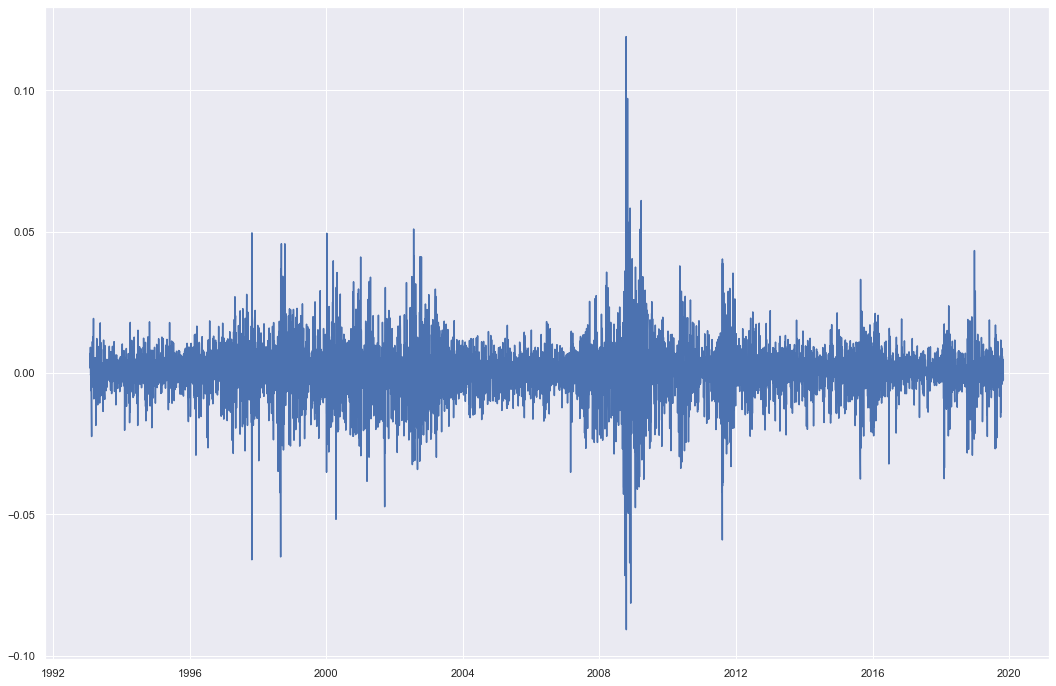

In [31]:
plt.plot(df['Date'], filtered_state.filtered_state[0, :]);

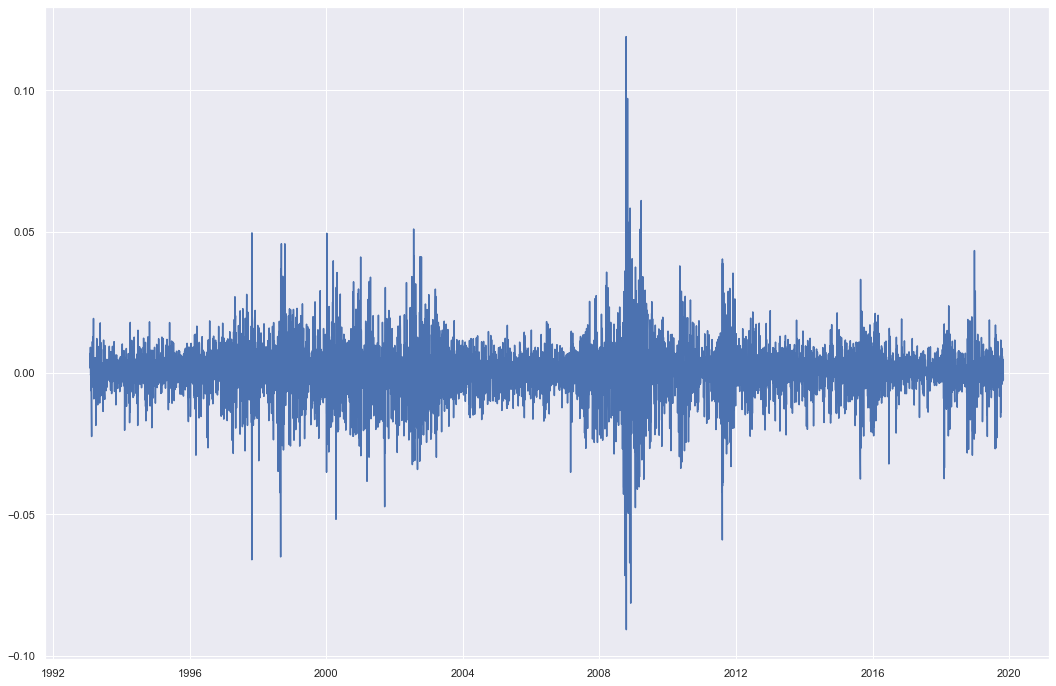

In [32]:
plt.plot(df['Date'], res.filtered_state[0, :]);

Smoothed equity premium

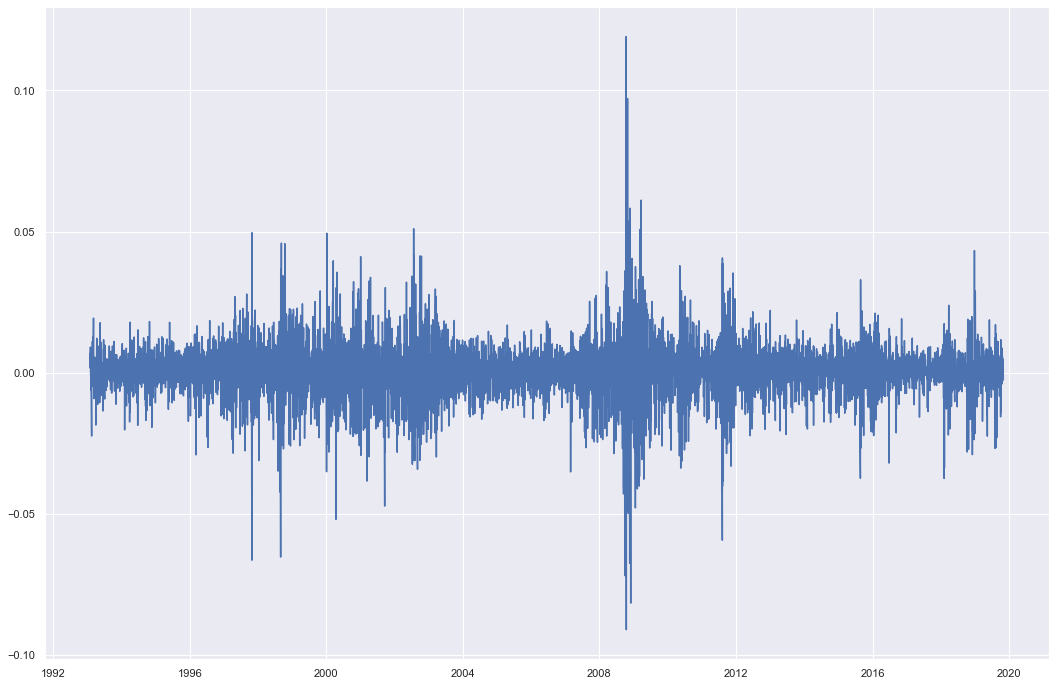

In [33]:
plt.plot(df['Date'], res.smoothed_state[0, :]);

#### Symbolic State Space

In [34]:
time_varying_equity_premium_model = ss.SymbolicTimeVaryingEquityPremiumModel(excess_returns=excess_returns)

TypeError: 
Data type not understood; expecting list of lists or lists of values.